# Ridge Detection

In [1]:
//load ImageJ
%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: scijava.public


net.imagej.ImageJ@3baf5137

This notebook contains tutorials on both `segment.detectRidges()` and `segment.detectJunctions()`, two closely related `Op`s. Note that this `Op` is separater from Thorsten Wagner's [Ridge Detection Plugin](https://imagej.net/Ridge_Detection).

In [2]:
ij.op().help('detectRidges')

Available operations:
	(List out) =
	net.imagej.ops.segment.detectRidges.DefaultDetectRidges(
		RandomAccessibleInterval in,
		double width,
		double lowerThreshold,
		double higherThreshold,
		int ridgeLengthMin)

In [3]:
ij.op().help('detectJunctions')

Available operations:
	(List out) =
	net.imagej.ops.segment.detectJunctions.DefaultDetectJunctions(
		List in,
		double threshold?)

Here we have an image of a line graph ([Source](http://imagej.net/images/LineGraph.jpg)). We will invert the image for use later on.

[INFO] Populating metadata
[INFO] Populating metadata


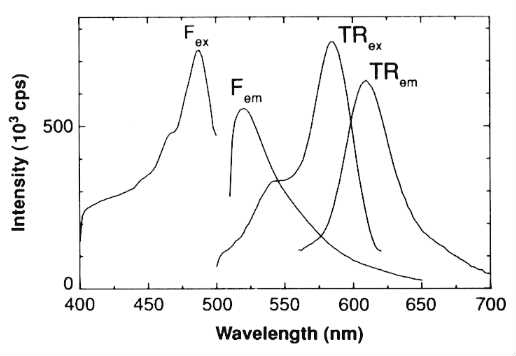

In [4]:
input = ij.scifio().datasetIO().open("https://imagej.net/images/LineGraph.jpg")
ij.notebook().display(input)                             

We will invert the image and crop the image so that we only get the graph:

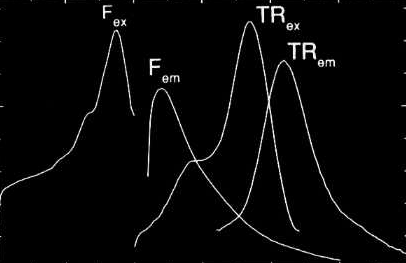

In [5]:
import net.imglib2.FinalInterval

inverted = ij.op().create().img(input)
ij.op().run("invert", inverted, input)
slice = FinalInterval.createMinMax(82, 20, 487, 282)
cropped = ij.op().run("crop", inverted, slice, true)
ij.notebook().display(cropped)        

Let's say that we want to find the intersections of the lines in the graph. To do this we first have to get a list of all of the lines, which can be done using `segment.detectRidges()`. The parameters required for `detectRidges()` can sometimes be confusing to a first-time user of the algorithm, so here is an explanation of what each of the confusing parameters signifies:

* `width`: This parameter describes the length of the diameter of the lines that we wish to extract, i.e. from left edge to right edge (NOT center to edge).

* `highThreshold`: This parameter describes the minimum pixel value at which the algorithm is allowed to declare a new line. The algorithm forms ridges by first finding the most "line-like" point and then recursively adding points to the line along both directions until the line ends. It then moves to the next most "line-like" point. We can estimate the value at which the most "line-like" point is actually not a line point at all by picking **a pixel value that is close (but a bit less than) the highest average pixel value on the lines**.

* `lowThreshold`: This parameter describes the minimum pixel value that the algorithm will consider a "line point". When adding 

In [6]:
//all of these parameters are easy to find in Fiji or in ImageJ

//the width of the line, from edge to edge
width = 1.3

//the higher threshold value declares the minimum starting value upon which a line can be declared. 
//i.e. every line found by the algorithm must contain a pixel value at least as high as this value.
highContrast = 150

//the lower threshold value declares the minimum value that is considered a line point.
//i.e. the algorithm will only consider a pixel value as a possible line point if it is above this value.
lowContrast = 30

//the minimum ridge length to be returned by the algorithm. 
//Useful to filter out skeletonized ridge ends and ridges caused by noise.
ridgeLengthMin = 10

lines = ij.op().run("detectRidges", cropped, width, lowContrast, highContrast, ridgeLengthMin)

println(lines.size())

27


null

Let's paint all of the lines that we found onto a blank image so that we can compare to the original:

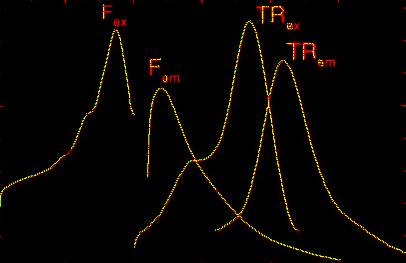

In [7]:
import net.imglib2.view.Views

//create img
linesImg = ij.op().create().img(cropped)
linesImgRA = linesImg.randomAccess()
maxValue = linesImg.firstElement().getMaxValue()

//paint each line onto the img
for(line in lines){
    //get each point
    for(int i = 0; i < line.numVertices(); i++){
        point = line.vertex(i)
        x = point.getDoublePosition(0) as int
        linesImgRA.setPosition(x, 0)
        y = point.getDoublePosition(1) as int
        linesImgRA.setPosition(y, 1)
        linesImgRA.get().setReal(maxValue)
    }
}

//combine the two images into one image with two channels
composite = Views.stack(cropped, linesImg)

ij.notebook().display(composite)

Now to find the intersections we have to use `detectJunctions`:

6


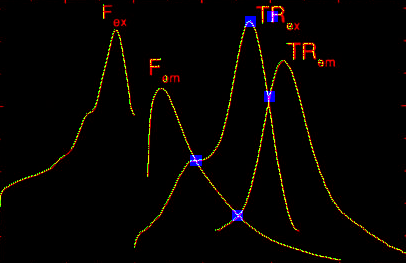

In [8]:
import net.imglib2.view.Views

threshold = Math.sqrt(2)

junctions = ij.op().run("detectJunctions", lines, threshold)
junctionsImg = ij.op().create().img(cropped)
junctionsImgRA = junctionsImg.randomAccess()

println(junctions.size())

for(junction in junctions){
    x = junction.getDoublePosition(0) as int
    y = junction.getDoublePosition(1) as int
    for(int dx = -5; dx < 6; dx++){
        for(int dy = -5; dy < 6; dy++){
            junctionsImgRA.setPosition(x + dx, 0)
            junctionsImgRA.setPosition(y + dy, 1)
            junctionsImgRA.get().setReal(maxValue)
        }
    }
}

completeComposite = Views.stack(cropped, linesImg, junctionsImg)

ij.notebook().display(completeComposite)

Note that (for the most part) `detectJunctions` was able to find all of the junctions in the image (as well as some faulty junctions that might be able to be removed by smoothing `detectRidges`' parameters).